In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchsummary import summary
from torcheval.metrics import BinaryPrecisionRecallCurve
import torchmetrics
from tqdm.notebook import tqdm
from torchmetrics import R2Score
from sklearn.metrics import precision_recall_curve, f1_score, classification_report
from comet_ml import Experiment
from sklearn import preprocessing 

%matplotlib inline

In [3]:
N=10
df=pd.read_csv('datasets/data.csv')
df=np.log(df[['e_mu_current', 'e_nu_1', 'e_nu_2', 'q_mu', 'q_nu1', 'q_nu2']])
df=df.rolling(window=N).mean()
df=df.iloc[N:]
df[['e_mu_current', 'e_nu_1', 'e_nu_2', 'q_mu', 'q_nu1', 'q_nu2']]=preprocessing.MinMaxScaler((0,1)).fit_transform(df[['e_mu_current', 'e_nu_1', 'e_nu_2', 'q_mu', 'q_nu1', 'q_nu2']])
df

,e_mu_current,e_nu_1,e_nu_2,q_mu,q_nu1,q_nu2
10,0.204035,0.199261,0.767866,0.874595,0.318002,0.037391
11,0.210023,0.209500,0.756762,0.874379,0.318208,0.041934
12,0.214285,0.225922,0.747887,0.874078,0.317966,0.042026
13,0.221820,0.229116,0.741759,0.872217,0.319699,0.042904
14,0.219946,0.215104,0.748768,0.871199,0.318909,0.044967
...,...,...,...,...,...,...
184845,0.144382,0.171057,0.799052,0.880731,0.334911,0.073597
184846,0.141849,0.177929,0.802874,0.880780,0.335035,0.071781
184847,0.138021,0.185297,0.815893,0.881368,0.336529,0.069684
184848,0.132465,0.186639,0.825226,0.880472,0.334482,0.065804


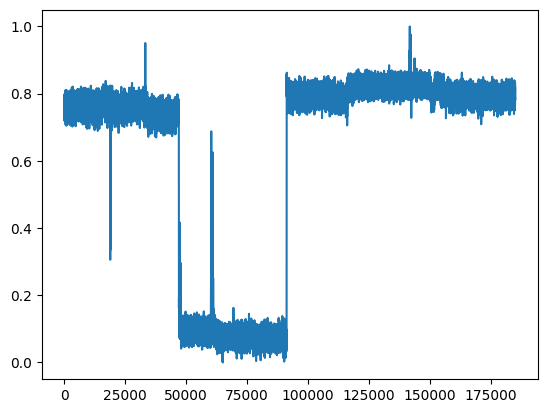

In [4]:
plt.plot(df['e_nu_2'])
plt.show()

In [5]:
df[['e_nu_1', 'e_nu_2', 'q_mu', 'q_nu1', 'q_nu2']].values

array([[0.19926095, 0.76786569, 0.8745948 , 0.3180017 , 0.03739127],
       [0.20949988, 0.75676213, 0.87437873, 0.31820824, 0.04193404],
       [0.22592228, 0.74788672, 0.87407751, 0.31796569, 0.04202562],
       ...,
       [0.18529716, 0.81589309, 0.8813677 , 0.33652875, 0.06968442],
       [0.18663861, 0.82522601, 0.88047223, 0.33448179, 0.06580381],
       [0.1867448 , 0.82919734, 0.88122729, 0.33417247, 0.0698388 ]])

In [6]:
df[['e_nu_1', 'e_nu_2', 'q_mu', 'q_nu1', 'q_nu2']].values.reshape((-1,1,10))[0]

array([[0.19926095, 0.76786569, 0.8745948 , 0.3180017 , 0.03739127,
        0.20949988, 0.75676213, 0.87437873, 0.31820824, 0.04193404]])

In [3]:
class BoxDataset(Dataset):
    
    @classmethod
    def __init__(self, df_path,N=10, windth=1):
        df=pd.read_csv(df_path)
        df=np.log(df)
        df=df.rolling(window=N).mean()
        df=df.iloc[N:]
        df[['e_mu_current', 'e_nu_1', 'e_nu_2', 'q_mu', 'q_nu1', 'q_nu2']]=preprocessing.MinMaxScaler((0,1)).fit_transform(df[['e_mu_current', 'e_nu_1', 'e_nu_2', 'q_mu', 'q_nu1', 'q_nu2']])
        self.data=df[['e_nu_1', 'e_nu_2', 'q_mu', 'q_nu1', 'q_nu2']].values[:-1]
        
        self.vectors = []
        for i, point in enumerate(self.data[:-windth]):
            self.vectors.append(self.data[i:windth+i,:].flatten())
        self.vectors=np.array(self.vectors)
        self.target=df['e_mu_current'].values[windth:]
        
        self.vectors = torch.FloatTensor(self.vectors)
        self.target = torch.FloatTensor(self.target)
    def __len__(self):
        return len(self.vectors)

    def __getitem__(self, idx):
        return {'vectors':self.vectors[idx], 'target':self.target[idx]}

In [7]:
test_len

36967

In [8]:
width=2
dataset=BoxDataset(df_path='datasets/data.csv',windth=width)

val_sptit = 0.2
batch_size = 1024

train_len = len(dataset) - int(len(dataset) * val_sptit)
test_len = int(len(dataset) * val_sptit)

train_set, val_set = torch.utils.data.random_split(dataset, [train_len, test_len])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                          drop_last=True)
test_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False,
                         drop_last=True)

C:\anaconda3\envs\torch\lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [9]:
class Net(nn.Module):
    def __init__(self,in_channels=1):
        super(Net, self).__init__()
        
        self.relu = nn.LeakyReLU()

        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=16,kernel_size=3)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32,kernel_size=3)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64,kernel_size=3)
        self.batch_norm3 = nn.BatchNorm1d(64)
        self.maxpool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128,kernel_size=3)
        self.batch_norm4 = nn.BatchNorm1d(128)
        self.maxpool4 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.fc1_1 = nn.Linear(in_features=192, out_features=256)
        self.anomaly = nn.Linear(in_features=256, out_features=1)


        for tensor in [self.conv1, self.conv2, self.conv3, self.conv4, self.fc1_1, self.anomaly]:
            torch.nn.init.kaiming_uniform_(tensor.weight)

    def forward(self, x):

        x = self.conv1(x)
        x = self.relu(x)
        x = self.batch_norm1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.batch_norm2(x)

        x = torch.flatten(x, 1)
        output1_1 = self.fc1_1(x)
        anomaly = self.anomaly(output1_1)
        anomaly=nn.Sigmoid()(anomaly)

        return anomaly

In [10]:
model = Net()

res = model.cuda()
summary(model, (1,10))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 16, 8]              64
         LeakyReLU-2                [-1, 16, 8]               0
       BatchNorm1d-3                [-1, 16, 8]              32
            Conv1d-4                [-1, 32, 6]           1,568
         LeakyReLU-5                [-1, 32, 6]               0
       BatchNorm1d-6                [-1, 32, 6]              64
            Linear-7                  [-1, 256]          49,408
            Linear-8                    [-1, 1]             257
Total params: 51,393
Trainable params: 51,393
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.20
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


In [ ]:
# log=False
log=True
if log==True:
    experiment = Experiment(
        api_key="5skWtD5KzMcU6rVhVNOLfQZ6E",
        project_name="qber-nn",
        workspace="dkagramanyan",
    )

device = 'cuda'
# device = 'cpu'

model.train()
model.to(device)

learning_rate = 0.001
# learning_rate = 0.1 * (batch_size / 256)

mse_loss=nn.MSELoss()

acc_metric=torchmetrics.classification.MulticlassAccuracy(num_classes=5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)

epochs_cnt = 10000
tbar = tqdm(range(epochs_cnt), leave=True, desc='?')


for epoch in tbar:

    for i, frames_series in enumerate(train_loader):

        vectors = frames_series['vectors'].to(device).reshape((-1,1,10))
        target = frames_series['target'].to(device)

        target_output = model(vectors)

        # MSe change point classification
        loss = mse_loss(torch.squeeze(target_output), target).to(device)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('train done ---')
        
    if epoch % 5 == 0:
        with torch.no_grad():
            r2score = R2Score().to(device)
            l1=nn.L1Loss()
            
            loss_list=[]
            r2score_list=[]
            l1_loss_list=[]

            for j, test_frames_series in enumerate(test_loader):
                vectors = test_frames_series['vectors'].to(device).reshape((-1,1,10))
                target = test_frames_series['target'].to(device)
        
                target_output = model(vectors)
        
                # BCE change point classification
                loss = mse_loss(torch.squeeze(target_output), target).to(device)
                loss_list.append(loss)
                
                # R2 metrics
                r2score_metrics=r2score(torch.squeeze(target_output), target)
                r2score_list.append(r2score_metrics)
                
                # L1 metrics
                l1_loss=l1(torch.squeeze(target_output), target)
                l1_loss_list.append(l1_loss_list)

            
            loss_t=torch.mean(torch.FloatTensor(loss_list))
            r2score_t=torch.mean(torch.FloatTensor(r2score_list))
            l1_t=np.mean(l1_loss_list)
            
            print('test done')

            msg = f'\nTest MSE Loss: {loss_t:.4f}\tR2 metrics: {r2score_t:.4f}\tL1 loss: {l1_t:.6f}'

            print(msg)
            if log==True:
                experiment.log_metric('Train MSE loss', loss.item())
                experiment.log_metric('Test MSE loss', loss_t)
                experiment.log_metric('Test R2  metrics', r2score_t)
                experiment.log_metric('Test L1 loss', l1_t)



In [ ]:
experiment.end()